# This notebook is to explore different methods of using unsupervised learning algorithms for tagging anomalies on the tweet data.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyod
from numpy.random import seed
import tensorflow as tf
from tensorflow.random import set_seed as set_random_seed
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

# Load up the data which has already been pre-processed

In [60]:
scaled_df = pd.read_csv('../data/processed/elonmusk_scaled_tweet_features.csv').drop('Unnamed: 0',axis='columns')

In [61]:
X = scaled_df.values
print (np.shape(X))
print (type(X))
X.shape[1]
ndim = X.shape[1] #the number of features

(9708, 20)
<class 'numpy.ndarray'>


# Configure up the various models to be tested

In [62]:
# Import lots of models from PyOD
from pyod.models.abod import ABOD
from pyod.models.sod import SOD
from pyod.models.cof import COF
from pyod.models.cblof import CBLOF
from pyod.models.lmdd import LMDD
from pyod.models.sos import SOS
from pyod.models.loci import LOCI
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.loda import LODA
from pyod.models.pca import PCA
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.mo_gaal import MO_GAAL

In [77]:
# Set the outliers_fraction to be 1%
outliers_fraction = 0.01
random_state = np.random.RandomState(42)
# Define eighteen outlier detection tools to be compared
classifiers = {
    'Variational Auto Econder (VAE)': VAE(epochs=20,
            contamination = outliers_fraction, random_state = random_state,
            encoder_neurons = [ndim,max(int(ndim/2),1),max(int(ndim/4),1)],
            decoder_neurons = [max(int(ndim/4),1),max(int(ndim/2),1),ndim],
            verbosity=0),
    'Fully Connected Auto Econder (AutoEncoder)': AutoEncoder(epochs=20,
        contamination=outliers_fraction,random_state=random_state,
        hidden_neurons = [ndim, max(int(ndim/2),1), max(int(ndim/4),1), 
                           max(int(ndim/4),1),max(int(ndim/2),1),ndim],
        verbose = 0),                                                        
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Subspace Outlier Detector (SOD)':
        SOD(contamination=outliers_fraction),
    'Connectivity-Based Outlier Factor (COF)':
        COF(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Deviation-based Outlier Detection (LMDD)':
        LMDD(contamination=outliers_fraction,
            random_state=random_state),
    'Stochastic Outlier Selection (SOS)':
        SOS(contamination=outliers_fraction,
           metric='correlation'),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Lightweight On-line Detector of Anomalies (LODA)':
        LODA(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state)
}

# Iterate and fit over the different models we have defined and save the output

In [78]:
# initialize results arrays
y_pred = np.array([])
scores_pred = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    clf.fit(X)
    if y_pred.shape == (0,):#if we haven't saved any data yet
        scores_pred = (clf.decision_function(X) * -1).reshape(1,X.shape[0])
        y_pred = (clf.predict(X)).reshape(1,X.shape[0])
    else: # we've got data stored in scores and y
        scores_pred = np.vstack(((clf.decision_function(X) * -1).reshape(1,X.shape[0]),scores_pred))
        y_pred = np.vstack(((clf.predict(X)).reshape(1,X.shape[0]),y_pred))

1 fitting Variational Auto Econder (VAE)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_101 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_101.
  warnings.warn(


2 fitting Fully Connected Auto Econder (AutoEncoder)
3 fitting Angle-based Outlier Detector (ABOD)
4 fitting Subspace Outlier Detector (SOD)
5 fitting Connectivity-Based Outlier Factor (COF)
6 fitting Cluster-based Local Outlier Factor (CBLOF)
7 fitting Deviation-based Outlier Detection (LMDD)
8 fitting Stochastic Outlier Selection (SOS)
9 fitting Feature Bagging
10 fitting Histogram-base Outlier Detection (HBOS)
11 fitting Isolation Forest
12 fitting K Nearest Neighbors (KNN)
13 fitting Average KNN
14 fitting Local Outlier Factor (LOF)
15 fitting Minimum Covariance Determinant (MCD)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


16 fitting One-class SVM (OCSVM)
17 fitting Lightweight On-line Detector of Anomalies (LODA)
18 fitting Principal Component Analysis (PCA)


In [7]:
# save backups
np.save('../y_pred_log.npy',y_pred)
np.save('../scores_pred_log.npy',scores_pred)

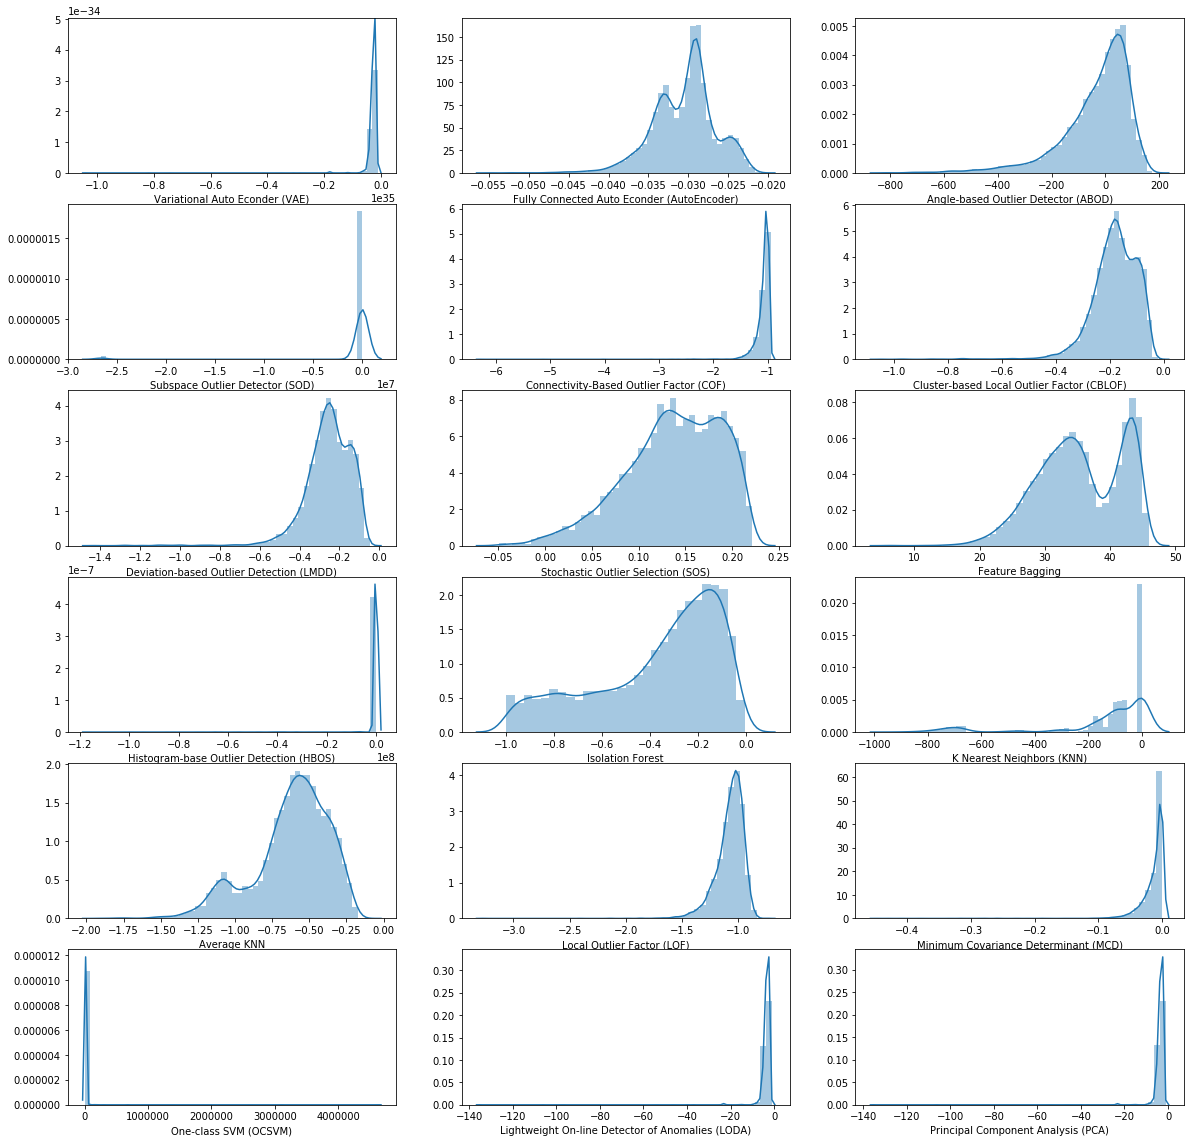

In [79]:
col_names = [clf_name for i, (clf_name,clf) in enumerate(classifiers.items())]
scores_df = pd.DataFrame(scores_pred.transpose(), columns = col_names,index = range(scores_pred.shape[1]))
fig, axes = plt.subplots(nrows=6, ncols=3,figsize=(20, 20))
for i, column in enumerate(scores_df.columns):
    sns.distplot(scores_df[column],ax=axes[i//3,i%3])

# Now we need to test our anomaly models for their trade rate success

In [80]:
import trade_utils as tu
import pytz
import datetime
# open up the processed tweet data
tweet_features_df = pd.read_csv('../data/cleaned/elonmusk_unscaled_tweet_features.csv')\
                               .drop('Unnamed: 0',axis='columns')
tweet_features_df['Time'] = pd.to_datetime(tweet_features_df['Time'])
tsla_df = pd.read_csv('../data/raw/tsla_stock_price.csv')\
                     .drop('Unnamed: 0',axis='columns')
tsla_df['DateTime'] = pd.to_datetime(tsla_df['DateTime'])
# unscaled_df['anomalous'] = y_pred
# some helper functions
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))
def nearest_price(items, pivot,df):
    timestamp = min(items, key=lambda x: abs(x - pivot))
    return df.loc[df['DateTime']==timestamp,['Open']].values
def strip_string(string):
    #return string.strip("[[]]")
    return string[0][0]
# insert the stock data into the appropriate rows on the tweet_features_df
#tweet_features_df['stock_time']=tweet_features_df['Time'].apply(lambda row: nearest(tsla_df['DateTime'],row))
#tweet_features_df['stock_price']=tweet_features_df['Time'].apply(lambda row: nearest_price(tsla_df['DateTime'],row,tsla_df))
#tweet_features_df['stock_price'] = tweet_features_df['stock_price'].apply(lambda row: strip_string(row))

In [81]:
tweet_features_df = pd.read_csv(\
            '../data/processed/elonmusk_anomalyandstock_tagged_tweet_features.csv')\
            .drop('Unnamed: 0',axis='columns')
tweet_features_df['Time'] = pd.to_datetime(tweet_features_df['Time'])
tweet_features_df['stock_time'] = pd.to_datetime(tweet_features_df['stock_time'])

In [82]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2016,1,1))
end_date = timezone.localize(datetime.datetime(2020,2,1))
# for each model, store the results:
returns = np.array([])
accuracies = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name, "anomalies")
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[i,:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy,best_total = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    # store the results
    returns = np.hstack((returns,best_return))
    accuracies = np.hstack((accuracies,best_accuracy))
    

1 fitting Variational Auto Econder (VAE) anomalies


/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


2 fitting Fully Connected Auto Econder (AutoEncoder) anomalies
3 fitting Angle-based Outlier Detector (ABOD) anomalies
4 fitting Subspace Outlier Detector (SOD) anomalies
5 fitting Connectivity-Based Outlier Factor (COF) anomalies
6 fitting Cluster-based Local Outlier Factor (CBLOF) anomalies
7 fitting Deviation-based Outlier Detection (LMDD) anomalies
8 fitting Stochastic Outlier Selection (SOS) anomalies
9 fitting Feature Bagging anomalies
10 fitting Histogram-base Outlier Detection (HBOS) anomalies
11 fitting Isolation Forest anomalies
12 fitting K Nearest Neighbors (KNN) anomalies
13 fitting Average KNN anomalies
14 fitting Local Outlier Factor (LOF) anomalies
15 fitting Minimum Covariance Determinant (MCD) anomalies
16 fitting One-class SVM (OCSVM) anomalies
17 fitting Lightweight On-line Detector of Anomalies (LODA) anomalies
18 fitting Principal Component Analysis (PCA) anomalies


In [83]:
# save backups
np.save('../../returns_log.npy',returns)
np.save('../../accuracies_log.npy',accuracies)

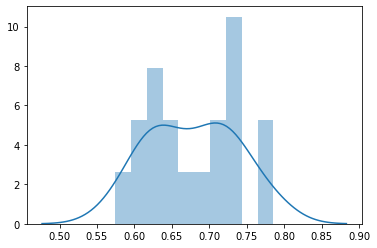

In [84]:
# let's have a look at the accuracy distributions
sns.distplot(accuracies,bins=10)

In [85]:
print(np.argwhere(accuracies >= .55))
accuracies[np.argwhere(accuracies >= .55)]

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [ 9]
 [10]
 [11]
 [12]
 [13]
 [14]
 [15]
 [16]
 [17]]


array([[0.72340426],
       [0.6097561 ],
       [0.62790698],
       [0.62962963],
       [0.68421053],
       [0.76470588],
       [0.70967742],
       [0.78571429],
       [0.67647059],
       [0.57407407],
       [0.73584906],
       [0.60869565],
       [0.625     ],
       [0.63934426],
       [0.70454545],
       [0.65454545],
       [0.72340426],
       [0.72340426]])

In [87]:
accuracies[10]

0.7358490566037735

# Now let's test over a different range of dates

In [17]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))
end_date = timezone.localize(datetime.datetime(2020,6,1))
# for each model, store the results:
returns_wide = np.array([])
accuracies_wide = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name, "anomalies")
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[i,:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    # store the results
    returns_wide = np.hstack((returns_wide,best_return))
    accuracies_wide = np.hstack((accuracies_wide,best_accuracy))

1 fitting Variational Auto Econder (VAE) anomalies


/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


2 fitting Fully Connected Auto Econder (AutoEncoder) anomalies
3 fitting Angle-based Outlier Detector (ABOD) anomalies
4 fitting Subspace Outlier Detector (SOD) anomalies
5 fitting Connectivity-Based Outlier Factor (COF) anomalies
6 fitting Cluster-based Local Outlier Factor (CBLOF) anomalies
7 fitting Deviation-based Outlier Detection (LMDD) anomalies
8 fitting Stochastic Outlier Selection (SOS) anomalies
9 fitting Feature Bagging anomalies
10 fitting Histogram-base Outlier Detection (HBOS) anomalies
11 fitting Isolation Forest anomalies
12 fitting K Nearest Neighbors (KNN) anomalies
13 fitting Average KNN anomalies
14 fitting Local Outlier Factor (LOF) anomalies
15 fitting Minimum Covariance Determinant (MCD) anomalies
16 fitting One-class SVM (OCSVM) anomalies
17 fitting Lightweight On-line Detector of Anomalies (LODA) anomalies
18 fitting Principal Component Analysis (PCA) anomalies


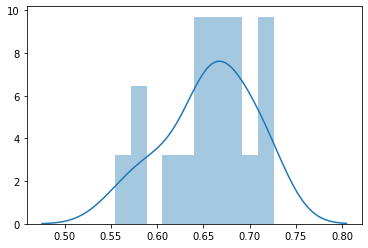

In [18]:
# let's have a look at the accuracy distributions
sns.distplot(accuracies_wide,bins=10)

In [22]:
print(np.argwhere(accuracies_wide >= .70))
accuracies_wide[np.argwhere(accuracies_wide >= .70)]

[[ 5]
 [10]
 [12]
 [14]]


array([[0.71052632],
       [0.72      ],
       [0.7260274 ],
       [0.70238095]])

## Okay, so the CBLOF model seems to be doing the best so far.  Let's change the outlier fraction and see if that impacts the success rate.  If increase the outlier fraction, the accuracy should drop because non-anomalies are being included in the anomaly sample.  Likewise, if we decrease the outlier fraction should decrease or stay stable.

In [21]:
# Set the outliers_fraction to be 3%
outliers_fraction = 0.03
random_state = np.random.RandomState(42)
# Define eighteen outlier detection tools to be compared
classifiers = {
    'Variational Auto Econder (VAE)': VAE(epochs=20,
            contamination = outliers_fraction, random_state = random_state,
            encoder_neurons = [ndim,max(int(ndim/2),1),max(int(ndim/4),1)],
            decoder_neurons = [max(int(ndim/4),1),max(int(ndim/2),1),ndim],
            verbosity=0),
    'Fully Connected Auto Econder (AutoEncoder)': AutoEncoder(epochs=20,
        contamination=outliers_fraction,random_state=random_state,
        hidden_neurons = [ndim, max(int(ndim/2),1), max(int(ndim/4),1), 
                           max(int(ndim/4),1),max(int(ndim/2),1),ndim],
        verbose = 0),                                                        
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Subspace Outlier Detector (SOD)':
        SOD(contamination=outliers_fraction),
    'Connectivity-Based Outlier Factor (COF)':
        COF(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Deviation-based Outlier Detection (LMDD)':
        LMDD(contamination=outliers_fraction,
            random_state=random_state),
    'Stochastic Outlier Selection (SOS)':
        SOS(contamination=outliers_fraction,
           metric='correlation'),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Lightweight On-line Detector of Anomalies (LODA)':
        LODA(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state)
}

# initialize results arrays
y_pred = np.array([])
scores_pred = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    clf.fit(X)
    if y_pred.shape == (0,):#if we haven't saved any data yet
        scores_pred = (clf.decision_function(X) * -1).reshape(1,X.shape[0])
        y_pred = (clf.predict(X)).reshape(1,X.shape[0])
    else: # we've got data stored in scores and y
        scores_pred = np.vstack(((clf.decision_function(X) * -1).reshape(1,X.shape[0]),scores_pred))
        y_pred = np.vstack(((clf.predict(X)).reshape(1,X.shape[0]),y_pred))

1 fitting Variational Auto Econder (VAE)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_5 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_5.
  warnings.warn(


2 fitting Fully Connected Auto Econder (AutoEncoder)
3 fitting Angle-based Outlier Detector (ABOD)
4 fitting Subspace Outlier Detector (SOD)
5 fitting Connectivity-Based Outlier Factor (COF)
6 fitting Cluster-based Local Outlier Factor (CBLOF)
7 fitting Deviation-based Outlier Detection (LMDD)
8 fitting Stochastic Outlier Selection (SOS)
9 fitting Feature Bagging
10 fitting Histogram-base Outlier Detection (HBOS)
11 fitting Isolation Forest
12 fitting K Nearest Neighbors (KNN)
13 fitting Average KNN
14 fitting Local Outlier Factor (LOF)
15 fitting Minimum Covariance Determinant (MCD)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


16 fitting One-class SVM (OCSVM)
17 fitting Lightweight On-line Detector of Anomalies (LODA)
18 fitting Principal Component Analysis (PCA)


In [23]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2016,1,1))
end_date = timezone.localize(datetime.datetime(2020,2,1))
# for each model, store the results:
returns_3pct = np.array([])
accuracies_3pct = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name, "anomalies")
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[i,:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    # store the results
    returns_3pct = np.hstack((returns_3pct,best_return))
    accuracies_3pct = np.hstack((accuracies_3pct,best_accuracy))

1 fitting Variational Auto Econder (VAE) anomalies


/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


2 fitting Fully Connected Auto Econder (AutoEncoder) anomalies
3 fitting Angle-based Outlier Detector (ABOD) anomalies
4 fitting Subspace Outlier Detector (SOD) anomalies
5 fitting Connectivity-Based Outlier Factor (COF) anomalies
6 fitting Cluster-based Local Outlier Factor (CBLOF) anomalies
7 fitting Deviation-based Outlier Detection (LMDD) anomalies
8 fitting Stochastic Outlier Selection (SOS) anomalies
9 fitting Feature Bagging anomalies
10 fitting Histogram-base Outlier Detection (HBOS) anomalies
11 fitting Isolation Forest anomalies
12 fitting K Nearest Neighbors (KNN) anomalies
13 fitting Average KNN anomalies
14 fitting Local Outlier Factor (LOF) anomalies
15 fitting Minimum Covariance Determinant (MCD) anomalies
16 fitting One-class SVM (OCSVM) anomalies
17 fitting Lightweight On-line Detector of Anomalies (LODA) anomalies
18 fitting Principal Component Analysis (PCA) anomalies


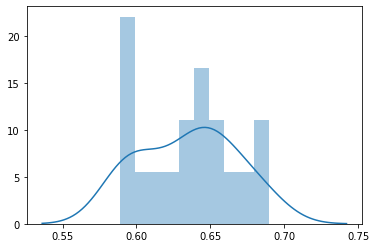

In [24]:
# let's have a look at the accuracy distributions
sns.distplot(accuracies_3pct,bins=10)

In [33]:
print(np.argwhere(accuracies_3pct >= .65))
accuracies_3pct[np.argwhere(accuracies_3pct >= .65)]

[[ 2]
 [ 4]
 [ 5]
 [ 7]
 [11]
 [15]]


array([[0.66141732],
       [0.65625   ],
       [0.68965517],
       [0.67256637],
       [0.65546218],
       [0.68115942]])

## Alright, so CBLOF is still the best,and all methods have dropped in accuracy as expected!  Now we'll do the extended timeframe fit.

In [27]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2012,1,1))
end_date = timezone.localize(datetime.datetime(2020,6,1))
# for each model, store the results:
returns_3pct_wide = np.array([])
accuracies_3pct_wide = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name, "anomalies")
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[i,:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    # store the results
    returns_3pct_wide = np.hstack((returns_3pct_wide,best_return))
    accuracies_3pct_wide = np.hstack((accuracies_3pct_wide,best_accuracy))

1 fitting Variational Auto Econder (VAE) anomalies


/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


2 fitting Fully Connected Auto Econder (AutoEncoder) anomalies
3 fitting Angle-based Outlier Detector (ABOD) anomalies
4 fitting Subspace Outlier Detector (SOD) anomalies
5 fitting Connectivity-Based Outlier Factor (COF) anomalies
6 fitting Cluster-based Local Outlier Factor (CBLOF) anomalies
7 fitting Deviation-based Outlier Detection (LMDD) anomalies
8 fitting Stochastic Outlier Selection (SOS) anomalies
9 fitting Feature Bagging anomalies
10 fitting Histogram-base Outlier Detection (HBOS) anomalies
11 fitting Isolation Forest anomalies
12 fitting K Nearest Neighbors (KNN) anomalies
13 fitting Average KNN anomalies
14 fitting Local Outlier Factor (LOF) anomalies
15 fitting Minimum Covariance Determinant (MCD) anomalies
16 fitting One-class SVM (OCSVM) anomalies
17 fitting Lightweight On-line Detector of Anomalies (LODA) anomalies
18 fitting Principal Component Analysis (PCA) anomalies


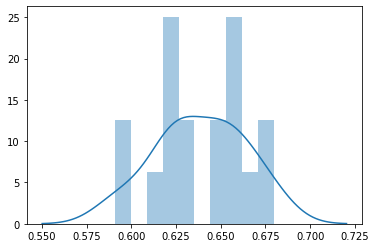

In [28]:
# let's have a look at the accuracy distributions
sns.distplot(accuracies_3pct_wide,bins=10)

In [32]:
print(np.argwhere(accuracies_3pct_wide >= .65))
accuracies_3pct_wide[np.argwhere(accuracies_3pct_wide >= .65)]

[[ 1]
 [ 2]
 [ 4]
 [ 5]
 [ 6]
 [12]
 [15]]


array([[0.65365854],
       [0.65346535],
       [0.67955801],
       [0.65625   ],
       [0.6686747 ],
       [0.65463918],
       [0.67355372]])

## As expected, the overall performance dropped slightly when including the longer time frame.  Let's try dropping the threshold to .5%

In [34]:
# Set the outliers_fraction to be .5%
outliers_fraction = 0.005
random_state = np.random.RandomState(42)
# Define eighteen outlier detection tools to be compared
classifiers = {
    'Variational Auto Econder (VAE)': VAE(epochs=20,
            contamination = outliers_fraction, random_state = random_state,
            encoder_neurons = [ndim,max(int(ndim/2),1),max(int(ndim/4),1)],
            decoder_neurons = [max(int(ndim/4),1),max(int(ndim/2),1),ndim],
            verbosity=0),
    'Fully Connected Auto Econder (AutoEncoder)': AutoEncoder(epochs=20,
        contamination=outliers_fraction,random_state=random_state,
        hidden_neurons = [ndim, max(int(ndim/2),1), max(int(ndim/4),1), 
                           max(int(ndim/4),1),max(int(ndim/2),1),ndim],
        verbose = 0),                                                        
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Subspace Outlier Detector (SOD)':
        SOD(contamination=outliers_fraction),
    'Connectivity-Based Outlier Factor (COF)':
        COF(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Deviation-based Outlier Detection (LMDD)':
        LMDD(contamination=outliers_fraction,
            random_state=random_state),
    'Stochastic Outlier Selection (SOS)':
        SOS(contamination=outliers_fraction,
           metric='correlation'),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Lightweight On-line Detector of Anomalies (LODA)':
        LODA(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state)
}

# initialize results arrays
y_pred = np.array([])
scores_pred = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    clf.fit(X)
    if y_pred.shape == (0,):#if we haven't saved any data yet
        scores_pred = (clf.decision_function(X) * -1).reshape(1,X.shape[0])
        y_pred = (clf.predict(X)).reshape(1,X.shape[0])
    else: # we've got data stored in scores and y
        scores_pred = np.vstack(((clf.decision_function(X) * -1).reshape(1,X.shape[0]),scores_pred))
        y_pred = np.vstack(((clf.predict(X)).reshape(1,X.shape[0]),y_pred))

1 fitting Variational Auto Econder (VAE)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_8 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_8.
  warnings.warn(


2 fitting Fully Connected Auto Econder (AutoEncoder)
3 fitting Angle-based Outlier Detector (ABOD)
4 fitting Subspace Outlier Detector (SOD)
5 fitting Connectivity-Based Outlier Factor (COF)
6 fitting Cluster-based Local Outlier Factor (CBLOF)
7 fitting Deviation-based Outlier Detection (LMDD)
8 fitting Stochastic Outlier Selection (SOS)
9 fitting Feature Bagging
10 fitting Histogram-base Outlier Detection (HBOS)
11 fitting Isolation Forest
12 fitting K Nearest Neighbors (KNN)
13 fitting Average KNN
14 fitting Local Outlier Factor (LOF)
15 fitting Minimum Covariance Determinant (MCD)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


16 fitting One-class SVM (OCSVM)
17 fitting Lightweight On-line Detector of Anomalies (LODA)
18 fitting Principal Component Analysis (PCA)


In [35]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2016,1,1))
end_date = timezone.localize(datetime.datetime(2020,6,1))
# for each model, store the results:
returns_half_prct = np.array([])
accuracies_half_prct = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name, "anomalies")
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[i,:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    # store the results
    returns_half_prct = np.hstack((returns_half_prct,best_return))
    accuracies_half_prct = np.hstack((accuracies_half_prct,best_accuracy))

1 fitting Variational Auto Econder (VAE) anomalies


/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


2 fitting Fully Connected Auto Econder (AutoEncoder) anomalies
3 fitting Angle-based Outlier Detector (ABOD) anomalies
4 fitting Subspace Outlier Detector (SOD) anomalies
5 fitting Connectivity-Based Outlier Factor (COF) anomalies
6 fitting Cluster-based Local Outlier Factor (CBLOF) anomalies
7 fitting Deviation-based Outlier Detection (LMDD) anomalies
8 fitting Stochastic Outlier Selection (SOS) anomalies
9 fitting Feature Bagging anomalies
10 fitting Histogram-base Outlier Detection (HBOS) anomalies
11 fitting Isolation Forest anomalies
12 fitting K Nearest Neighbors (KNN) anomalies
13 fitting Average KNN anomalies
14 fitting Local Outlier Factor (LOF) anomalies
15 fitting Minimum Covariance Determinant (MCD) anomalies
16 fitting One-class SVM (OCSVM) anomalies
17 fitting Lightweight On-line Detector of Anomalies (LODA) anomalies
18 fitting Principal Component Analysis (PCA) anomalies


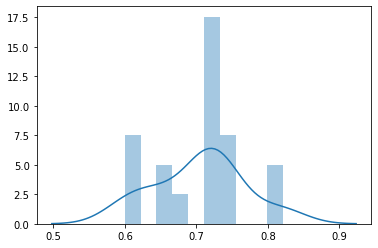

In [36]:
# let's have a look at the accuracy distributions
sns.distplot(accuracies_half_prct,bins=10)

In [37]:
print(np.argwhere(accuracies_half_prct >= .8))
accuracies_half_prct[np.argwhere(accuracies_half_prct >= .8)]

[[ 1]
 [11]]


array([[0.82142857],
       [0.8125    ]])

In [38]:
accuracies_half_prct

array([0.71428571, 0.82142857, 0.73529412, 0.675     , 0.61904762,
       0.75      , 0.65      , 0.64705882, 0.71428571, 0.60526316,
       0.71428571, 0.8125    , 0.73684211, 0.6       , 0.73076923,
       0.72727273, 0.71428571, 0.71428571])

In [40]:
np.sum(y_pred,axis=1)

array([49, 49, 49, 49, 47, 24, 46, 49, 49, 48, 49, 49, 49, 49, 49, 65, 49,
       49])

## Just to push things a bit further, we should see stochasticity in the results distribution if we take the threshold for anomaly even further down.

In [41]:
# Set the outliers_fraction to be .1%
outliers_fraction = 0.001
random_state = np.random.RandomState(42)
# Define eighteen outlier detection tools to be compared
classifiers = {
    'Variational Auto Econder (VAE)': VAE(epochs=20,
            contamination = outliers_fraction, random_state = random_state,
            encoder_neurons = [ndim,max(int(ndim/2),1),max(int(ndim/4),1)],
            decoder_neurons = [max(int(ndim/4),1),max(int(ndim/2),1),ndim],
            verbosity=0),
    'Fully Connected Auto Econder (AutoEncoder)': AutoEncoder(epochs=20,
        contamination=outliers_fraction,random_state=random_state,
        hidden_neurons = [ndim, max(int(ndim/2),1), max(int(ndim/4),1), 
                           max(int(ndim/4),1),max(int(ndim/2),1),ndim],
        verbose = 0),                                                        
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Subspace Outlier Detector (SOD)':
        SOD(contamination=outliers_fraction),
    'Connectivity-Based Outlier Factor (COF)':
        COF(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Deviation-based Outlier Detection (LMDD)':
        LMDD(contamination=outliers_fraction,
            random_state=random_state),
    'Stochastic Outlier Selection (SOS)':
        SOS(contamination=outliers_fraction,
           metric='correlation'),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Lightweight On-line Detector of Anomalies (LODA)':
        LODA(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state)
}

# initialize results arrays
y_pred = np.array([])
scores_pred = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name)
    clf.fit(X)
    if y_pred.shape == (0,):#if we haven't saved any data yet
        scores_pred = (clf.decision_function(X) * -1).reshape(1,X.shape[0])
        y_pred = (clf.predict(X)).reshape(1,X.shape[0])
    else: # we've got data stored in scores and y
        scores_pred = np.vstack(((clf.decision_function(X) * -1).reshape(1,X.shape[0]),scores_pred))
        y_pred = np.vstack(((clf.predict(X)).reshape(1,X.shape[0]),y_pred))

1 fitting Variational Auto Econder (VAE)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_11 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_11.
  warnings.warn(


2 fitting Fully Connected Auto Econder (AutoEncoder)
3 fitting Angle-based Outlier Detector (ABOD)
4 fitting Subspace Outlier Detector (SOD)
5 fitting Connectivity-Based Outlier Factor (COF)
6 fitting Cluster-based Local Outlier Factor (CBLOF)
7 fitting Deviation-based Outlier Detection (LMDD)
8 fitting Stochastic Outlier Selection (SOS)
9 fitting Feature Bagging
10 fitting Histogram-base Outlier Detection (HBOS)
11 fitting Isolation Forest
12 fitting K Nearest Neighbors (KNN)
13 fitting Average KNN
14 fitting Local Outlier Factor (LOF)
15 fitting Minimum Covariance Determinant (MCD)


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


16 fitting One-class SVM (OCSVM)
17 fitting Lightweight On-line Detector of Anomalies (LODA)
18 fitting Principal Component Analysis (PCA)


In [42]:
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2016,1,1))
end_date = timezone.localize(datetime.datetime(2020,6,1))
# for each model, store the results:
returns_tenth_prct = np.array([])
accuracies_tenth_prct = np.array([])
for i, (clf_name,clf) in enumerate(classifiers.items()):
    print(i + 1, 'fitting', clf_name, "anomalies")
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[i,:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    # store the results
    returns_tenth_prct = np.hstack((returns_tenth_prct,best_return))
    accuracies_tenth_prct = np.hstack((accuracies_tenth_prct,best_accuracy))

1 fitting Variational Auto Econder (VAE) anomalies


/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)


2 fitting Fully Connected Auto Econder (AutoEncoder) anomalies


/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:272: RuntimeWarning: invalid value encountered in double_scalars
  sum(temp1[:,6])/sum(temp1[:,7])]


3 fitting Angle-based Outlier Detector (ABOD) anomalies
4 fitting Subspace Outlier Detector (SOD) anomalies
5 fitting Connectivity-Based Outlier Factor (COF) anomalies
6 fitting Cluster-based Local Outlier Factor (CBLOF) anomalies
7 fitting Deviation-based Outlier Detection (LMDD) anomalies
8 fitting Stochastic Outlier Selection (SOS) anomalies
9 fitting Feature Bagging anomalies
10 fitting Histogram-base Outlier Detection (HBOS) anomalies
11 fitting Isolation Forest anomalies
12 fitting K Nearest Neighbors (KNN) anomalies
13 fitting Average KNN anomalies
14 fitting Local Outlier Factor (LOF) anomalies
15 fitting Minimum Covariance Determinant (MCD) anomalies
16 fitting One-class SVM (OCSVM) anomalies
17 fitting Lightweight On-line Detector of Anomalies (LODA) anomalies
18 fitting Principal Component Analysis (PCA) anomalies


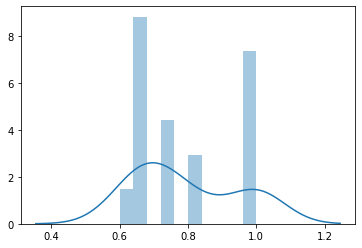

In [43]:
# let's have a look at the accuracy distributions
sns.distplot(accuracies_tenth_prct,bins=10)

In [45]:
print(np.argwhere(accuracies_tenth_prct >= .8))
accuracies_tenth_prct[np.argwhere(accuracies_tenth_prct >= .8)]

[[ 2]
 [ 5]
 [ 6]
 [ 7]
 [ 8]
 [12]
 [15]]


<ipython-input-45-533506bcea37>:1: RuntimeWarning: invalid value encountered in greater_equal
  print(np.argwhere(accuracies_tenth_prct >= .8))
<ipython-input-45-533506bcea37>:2: RuntimeWarning: invalid value encountered in greater_equal
  accuracies_tenth_prct[np.argwhere(accuracies_tenth_prct >= .8)]


array([[0.83333333],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.8       ]])

## Yup, it looks like the performance wanders all over the place once the number of anomalies ~ 10.

# Time to do a serious scan of a few techniques.  VAE and CBLOF have been good performers up to now.  Let's map their performance as a function of the outliers_fraction.

In [55]:
import trade_utils as tu
import pytz
import datetime
outliers_frac_list = 10.**np.linspace(-2.5,-1.5,10)
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2016,1,1))
end_date = timezone.localize(datetime.datetime(2020,2,1))
VAE_accuracy = np.array([])
VAE_total_anom = np.array([])
CBLOF_accuracy = np.array([])
CBLOF_total_anom = np.array([])
i = 0
for outlier in outliers_frac_list:
    print ("fitting level ",i+1)
    i+=1
    #fit the VAE
    clf1 = VAE(epochs=20,
            contamination = outlier, random_state = random_state,
            encoder_neurons = [ndim,max(int(ndim/2),1),max(int(ndim/4),1)],
            decoder_neurons = [max(int(ndim/4),1),max(int(ndim/2),1),ndim],
            verbosity=0)
    clf1.fit(X)
    # the predictions
    y_pred = clf1.predict(X)
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy,best_total = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    VAE_accuracy = np.hstack((VAE_accuracy,best_accuracy))
    VAE_total_anom = np.hstack((VAE_total_anom,best_total))
    
    #fit the CBLOF
    clf2 = CBLOF(contamination=outlier,
              check_estimator=False, random_state=random_state)
    clf2.fit(X)
    # the predictions
    y_pred = clf2.predict(X)
    # tag the tweets with this model's predictions for anomalies
    tweet_features_df['anomalous'] = y_pred[:]
    # trim down to the anomalies only
    anomaly_only_df = tweet_features_df[tweet_features_df['anomalous']!=0.]
    # compute the best performance
    params,best_return,best_accuracy,best_total = tu.find_best_performance(tsla_df,anomaly_only_df,start_date,end_date)
    CBLOF_accuracy = np.hstack((CBLOF_accuracy,best_accuracy))
    CBLOF_total_anom = np.hstack((CBLOF_total_anom,best_total))
    

fitting level  1


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_68 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_68.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  2


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_71 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_71.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  3


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_74 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_74.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  4


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_77 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_77.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  5


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_80 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_80.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  6


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_83 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_83.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  7


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_86 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_86.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  8


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_89 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_89.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  9


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_92 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_92.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

fitting level  10


/Users/JJ/opt/anaconda3/envs/insight/lib/python3.8/site-packages/keras/engine/training_utils.py:816: UserWarning: Output model_95 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_95.
  warnings.warn(
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['temporary'] = df.apply(lambda row : (row[time_column] - start_time).total_seconds(),axis=1)
/Users/JJ/Insight/projects/Muskometer/Insight-Data-Science-Project/notebooks/trade_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [56]:
print(VAE_accuracy)
print(VAE_total_anom)
print(CBLOF_accuracy)
print(CBLOF_total_anom)


[0.71428571 0.8        0.78571429 0.875      0.81578947 0.70175439
 0.69736842 0.68181818 0.63302752 0.6015625 ]
[  7.  10.  14.  24.  38.  57.  76.  88. 109. 128.]
[0.85714286 0.75       0.79166667 0.78947368 0.625      0.66666667
 0.64788732 0.68627451 0.63157895 0.63380282]
[  7.  12.  24.  19.  32.  33.  71.  51. 114. 142.]


## Now to calculate the average accuracies of randomly guessing which tweets are important so we can construct a t-test statistic for the accuracies of our chosen models.

In [35]:
def choose_random_tweets_optimize(tsla_df,anomalies_df,start_date,end_date,
                                    nsamples):
    #from previous results: 
    pos_lims = np.linspace(0.,1.,6)
    neg_lims = np.linspace(0.,1.,6)
    buy_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    sell_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    pos_rules = ['buy','sell']
    neu_rules = ['buy','sell']
    neg_rules = ['buy','sell']
    #create initial array to old the output of each run
    final_results = np.array([])
    for i in range(100):#do one thousand samples
        #make fake list of anomalies from real tweets
        #using the real sentiment values from each
        anomaly_only_df = anomalies_df[(anomalies_df['stock_time'] >= start_date) & \
                                        (anomalies_df['stock_time'] <= end_date)]\
                          .sample(nsamples).sort_values(by=['stock_time'])
        #convert dataframes to numpy input
        tsla_np,anomaly_only_np,dummy1,dummy2,start_time,end_time = \
                tu.convert_dataframes_to_numpy(start_date,end_date,tsla_df,anomaly_only_df,
                                            datetime.timedelta(days=1),datetime.timedelta(days=1))
        algo_opt = grid_search_training_algo(tsla_df,anomaly_only_df,start_date,end_date)
        #indices of the tuning parameters that produce the best ROI performance
        op_i = np.argwhere(np.amax(algo_opt[:,:,:,:,:,0]) == algo_opt[:,:,:,:,:,0])[0]
        #uncomment these lines for true random buy/sell orders
        run1,temp1 = tu.asset_strategy_calculation_numpy\
                                            (pos_lims[op_i[0]],neg_lims[op_i[1]],5000.,5000.,\
                                            buy_delays,sell_delays,anomaly_only_np,\
                                            tsla_np,start_time,end_time,pos_rules[op_i[2]],\
                                            neu_rules[op_i[3]],neg_rules[op_i[4]],rand_flag = False)
        if final_results.shape == (0,):#if this is the first run through
            final_results = run1.reshape(1,run1.shape[0],run1.shape[1])
        else:#stack the results into a single numpy array
            final_results = np.vstack((run1.reshape(1,run1.shape[0],run1.shape[1]),final_results))
    return final_results

def grid_search_training_algo(tsla_df,anomaly_only_df,start_date,end_date):
    #parameters
    #timezone = pytz.timezone('UTC')
    #start_date = timezone.localize(datetime.datetime(2015,1,1))
    #end_date = timezone.localize(datetime.datetime(2015,1,1))
    pos_lims = np.linspace(0.,1.,6)
    neg_lims = np.linspace(0.,1.,6)
    buy_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    sell_delays = 86400.#np.linspace(1,10,10)*86400. # delay time in seconds
    pos_rules = ['buy','sell']
    neu_rules = ['buy','sell']
    neg_rules = ['buy','sell']
    #convert dataframes to numpy input
    tsla_np,anomaly_only_np,sell_delay,buy_delay,start_time,end_time = \
            tu.convert_dataframes_to_numpy(start_date,end_date,tsla_df,\
                                        anomaly_only_df,\
                                        datetime.timedelta(days=1),\
                                        datetime.timedelta(days=1))
    #array for output
    #use fractional performance as the test metric
    output = np.zeros([len(pos_lims),len(neg_lims),2,2,2,2],np.double)
    for i in range(len(pos_lims)):
        for j in range(len(neg_lims)):
    #for k in range(len(buy_delays)):
        #for l in range(len(sell_delays)):
            for m in range(2):
                for n in range(2):
                    for o in range(2):
                        #print (i,j,k,l,m,n,o)
                        #print (pl,nl,buy_d,sell_d,posr,neur,negr,start_time)
                        temp1,temp2 = tu.asset_strategy_calculation_numpy\
                                    (pos_lims[i],neg_lims[j],5000.,5000.,\
                                    buy_delays,sell_delays,anomaly_only_np,\
                                    tsla_np,start_time,end_time,pos_rules[m],\
                                    neu_rules[n],neg_rules[o])
                        # this is the total value in index 1 and trade 
                        # success rate in index 2
                        output[i,j,m,n,o,:] = [temp1[-1,4],\
                                              sum(temp1[:,6])/sum(temp1[:,7])] 
                                
    return output

In [51]:
import trade_utils as tu
import pytz
import datetime
outliers_frac_list = 10.**np.linspace(-2.5,-1.5,10)
timezone = pytz.timezone('UTC')
start_date = timezone.localize(datetime.datetime(2016,1,1))
end_date = timezone.localize(datetime.datetime(2020,2,1))
VAE_mock_accuracy = np.array([])
CBLOF_mock_accuracy = np.array([])
VAE_mock_variance = np.array([])
CBLOF_mock_variance = np.array([])
VAE_history = np.zeros([len(VAE_total_anom),100])
CBLOF_history = np.zeros([len(VAE_total_anom),100])
for i in range(len(VAE_total_anom)):
    print ("generating frame ",i)
    # because the number of anomalies in the chosen time frame are different between the two models under
    # consideration, we must do a unique random realization for both
    # VAE realization
    result1 = choose_random_tweets_optimize(tsla_df,tweet_features_df,start_date,end_date,
                                    int(VAE_total_anom[i]))
    # mean(successes over total trades)
    VAE_history[i,:] = np.sum(result1[:,:,6],axis=1)/np.sum(result1[:,:,7],axis=1)
    mock_accuracy1 = (np.sum(result1[:,:,6],axis=1)/np.sum(result1[:,:,7],axis=1)).mean() 
    VAE_mock_accuracy = np.hstack((VAE_mock_accuracy,mock_accuracy1))
    mock_variance1 = (np.sum(result1[:,:,6],axis=1)/np.sum(result1[:,:,7],axis=1)).var() 
    VAE_mock_variance = np.hstack((VAE_mock_variance,mock_variance1))
    print ("VAE complete, starting CBLOF ...")
    # CBLOF realization
    result2 = choose_random_tweets_optimize(tsla_df,tweet_features_df,start_date,end_date,
                                    int(CBLOF_total_anom[i]))
    # mean(successes over total trades)
    CBLOF_history[i,:] = np.sum(result2[:,:,6],axis=1)/np.sum(result2[:,:,7],axis=1)
    mock_accuracy2 = (np.sum(result2[:,:,6],axis=1)/np.sum(result2[:,:,7],axis=1)).mean() 
    CBLOF_mock_accuracy = np.hstack((CBLOF_mock_accuracy,mock_accuracy2))
    mock_variance2 = (np.sum(result2[:,:,6],axis=1)/np.sum(result2[:,:,7],axis=1)).var() 
    CBLOF_mock_variance = np.hstack((CBLOF_mock_variance,mock_variance2))
    

generating frame  0
VAE complete, starting CBLOF ...
generating frame  1
VAE complete, starting CBLOF ...
generating frame  2
VAE complete, starting CBLOF ...
generating frame  3
VAE complete, starting CBLOF ...
generating frame  4
VAE complete, starting CBLOF ...
generating frame  5
VAE complete, starting CBLOF ...
generating frame  6
VAE complete, starting CBLOF ...
generating frame  7
VAE complete, starting CBLOF ...
generating frame  8
VAE complete, starting CBLOF ...
generating frame  9
VAE complete, starting CBLOF ...


In [52]:
np.save('../../VAE_accuracy.npy',VAE_accuracy)
np.save('../../VAE_total_anom.npy',VAE_total_anom)
np.save('../../CBLOF_accuracy.npy',CBLOF_accuracy)
np.save('../../CBLOF_total_anom.npy',CBLOF_total_anom)
np.save('../../VAE_mock_accuracy.npy',VAE_mock_accuracy)
np.save('../../CBLOF_mock_accuracy.npy',CBLOF_mock_accuracy)
np.save('../../VAE_mock_variance.npy',VAE_mock_variance)
np.save('../../CBLOF_mock_variance.npy',CBLOF_mock_variance)
np.save('../../VAE_history.npy',VAE_history)
np.save('../../CBLOF_history.npy',CBLOF_history)


In [64]:
print(VAE_accuracy)
print(VAE_mock_accuracy)

[0.71428571 0.8        0.78571429 0.875      0.81578947 0.70175439
 0.69736842 0.68181818 0.63302752 0.6015625 ]
[0.78666667 0.73783333 0.6445304  0.62901214 0.61850314 0.61327542
 0.61057854 0.61054836 0.61021654 0.61238125]


In [65]:
10.**np.linspace(-2.5,-1.5,10)

array([0.00316228, 0.00408424, 0.005275  , 0.00681292, 0.00879923,
       0.01136464, 0.01467799, 0.01895736, 0.02448437, 0.03162278])

In [66]:
print(CBLOF_accuracy)
print(CBLOF_mock_accuracy)

[0.85714286 0.75       0.79166667 0.78947368 0.625      0.66666667
 0.64788732 0.68627451 0.63157895 0.63380282]
[0.77952381 0.71189394 0.66449892 0.63679292 0.63586454 0.62502892
 0.60344343 0.60456875 0.60896149 0.6071331 ]


## Make a visualization of the statistical significance and success rate of the VAE and CBLOF models as we scale the outlier fraction.

In [88]:
from scipy.stats import ttest_ind

In [104]:
def get_dummy_dist(mean,total):
    # returns a dummy distribution to use with ttest_ind
    # for the anomaly detection model scan
    output = np.zeros([int(total)])
    for i in range(int(mean*total)):#put a one in the output for each successful trade, 0 for failure
        output[i] = 1.
    #print ("Sanity check: ",mean," = ",sum(output)/total)
    return output

In [105]:
get_dummy_dist(VAE_accuracy[3],VAE_total_anom[3])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0.])

In [113]:
def get_Welchs_t_stats(history,accuracy,total):
    t_stat = np.zeros([history.shape[0]])
    p_value = np.zeros([history.shape[0]])
    for i in range(history.shape[0]):
        result = ttest_ind(get_dummy_dist(accuracy[i],total[i]),history[i,:],equal_var=False)
        t_stat[i] = result[0]
        p_value[i] = result[1]/2. #only want the one sided P-value
    return t_stat,p_value

In [115]:
VAE_t,VAE_p = get_Welchs_t_stats(VAE_history,VAE_accuracy,VAE_total_anom)
CBLOF_t,CBLOF_p = get_Welchs_t_stats(CBLOF_history,CBLOF_accuracy,CBLOF_total_anom)

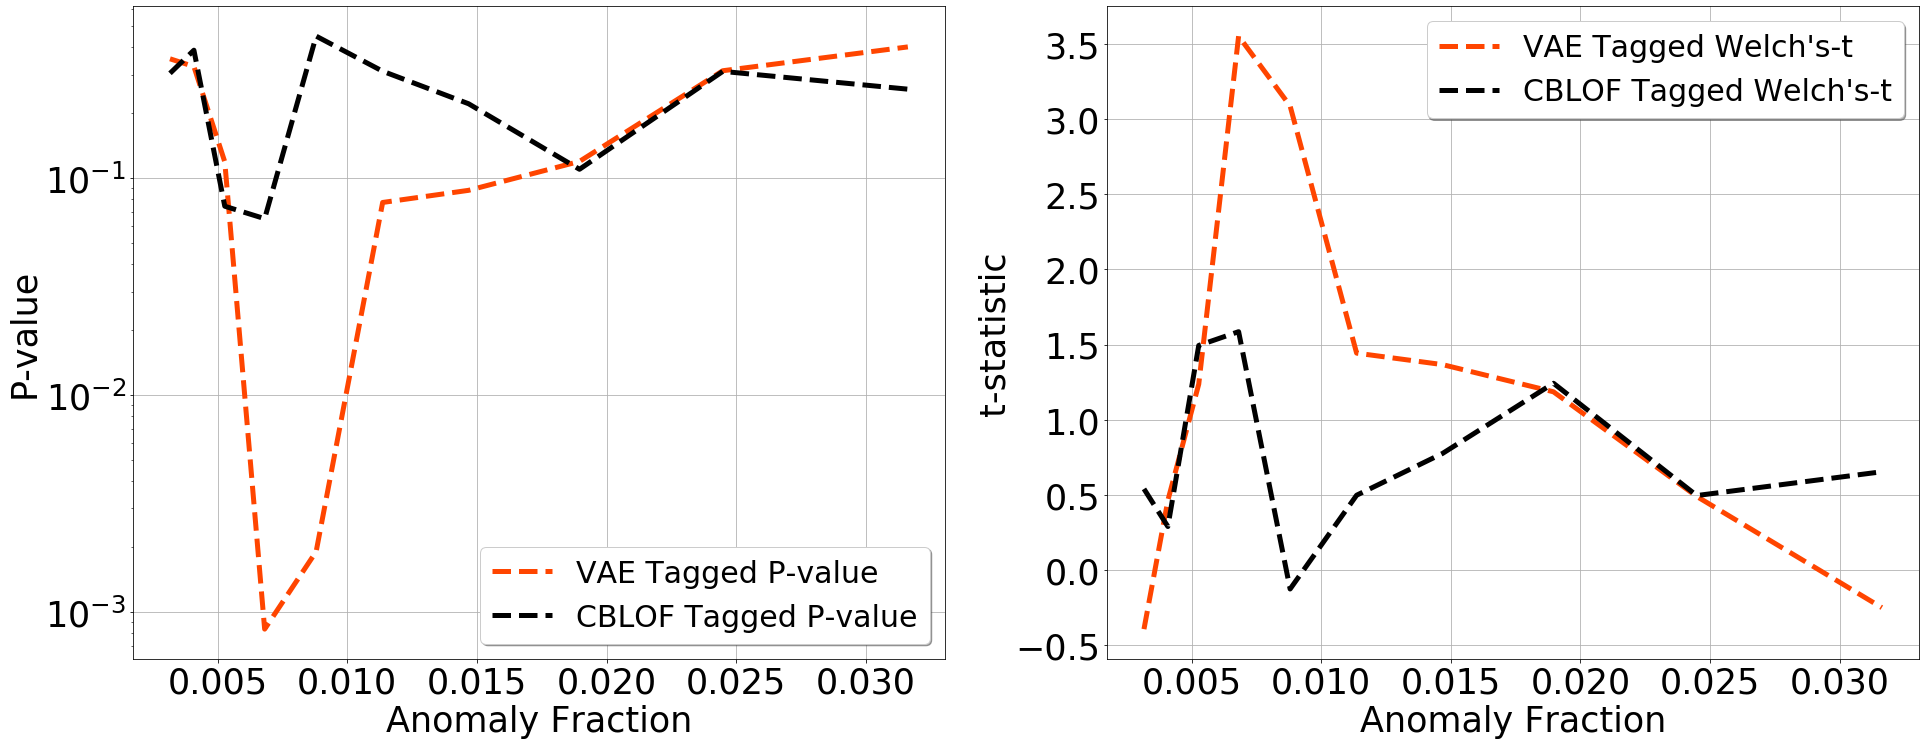

In [131]:
fig, ax = plt.subplots(1,2,figsize=(32,12))
outlier_frac = 10.**np.linspace(-2.5,-1.5,10)
ax[0].plot(outlier_frac,VAE_p,lw = 5,ls='--',label='VAE Tagged P-value',color='orangered')
ax[1].plot(outlier_frac,VAE_t,lw = 5,ls='--',label="VAE Tagged Welch's-t",color='orangered')
ax[0].plot(outlier_frac,CBLOF_p,lw = 5,ls='--',label='CBLOF Tagged P-value',color='black')
ax[1].plot(outlier_frac,CBLOF_t,lw = 5,ls='--',label="CBLOF Tagged Welch's-t",color='black')
ax[0].legend(loc='lower right', shadow=True,prop={'size': 30})
ax[1].legend(loc='upper right', shadow=True,prop={'size': 30})
ax[0].set_xlabel("Anomaly Fraction",fontsize=35)
ax[1].set_xlabel("Anomaly Fraction",fontsize=35)
ax[0].set_ylabel("P-value",fontsize=35)
ax[1].set_ylabel("t-statistic",fontsize=35)
for tick in ax[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(35)
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(35)
ax[0].set_yscale("log")
#ax[0].set_xscale("log")
#ax[1].set_xscale("log")
ax[0].grid()
ax[1].grid()
